# Predicting Heart Disease in Patients

Names: Michael Zheng, Zain Imran, Ella Mo, Yuhao Fu

### Introduction

A significant portion of deaths each year can be attributed to heart disease. As such, it is critical and essential to determine the common manifestations of heart disease so that we can better understand the conditions which heart disease can develop from and provide timely treatment. In this project, our group will use the data provided by Janosi et al. to find the relationship between various potentially related factors and the occurrence of heart disease. In this way, we may predict the diagnosis of heart disease more precisely and efficiently according to these factors.

The variables in in the original table are:
- Age
- Sex
- Chest pain (cp)
- Resting blood pressure in mmHg (trestbps)
- Serum cholesterol in mg/dl (chol)
- Fasting blood sugar in mg/dl (fbs)
- Resting electrocardiography (restecg)
- Maximum heart rate achieved (thalach)
- Exercise induced angina (exang)
- ST depression induced by exercise relative to rest (oldpeak)
- Slope of peak exercise ST segment (slope)
- Number of major vessels(0-3) coloured by fluoroscopy (ca)
- Blood disorder (thal)
- Diagnosis of heart disease (num)




Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R. (1988). *Heart Disease*. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

### Preliminary Data Analysis

In [14]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Here we call the data, name the columns, convert the categorical variables to factors, and rename the "num" column to "diagnosis"
# We also changed the "diagnosis" into categorical values and the turned them into factors
# We also removed any rows with missing values as they can create problems for our predictions 
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_disease_prelim_data <- read_csv(url, 
                               col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
                                             "exang", "oldpeak", "slope", "ca", "thal", "num")) |> 
mutate(sex = as_factor(sex)) |> 
mutate(sex = fct_recode(sex, "male" = "1", "female" = "0")) |> 
mutate(cp = as_factor(cp)) |> 
mutate(cp = fct_recode(cp, "typical_angina" = "1", "atypical_angina" = "2", "non_anginal_pain" = "3", "asymptomatic" = "4")) |> 
mutate(fbs = as_factor(fbs)) |> 
mutate(fbs = fct_recode(fbs, "true" = "1", "false" = "0")) |> 
mutate(restecg = as_factor(restecg)) |> 
mutate(restecg = fct_recode(restecg, "STT_wave_abnormality" = "1", "Normal" = "0", "ventricular_hypertrophy" = "2")) |> 
mutate(exang = as_factor(exang)) |> 
mutate(exang = fct_recode(exang, "yes" = "1", "no" = "0")) |> 
mutate(slope = as_factor(slope)) |> 
mutate(slope = fct_recode(slope, "upsloping" = "1", "flat" = "2", "downsloping" = "3")) |> 
mutate(thal = as_factor(thal)) |> 
mutate(thal = fct_recode(thal, "reversable_defect" = "7.0", "fixed_defect" = "6.0", "normal" = "3.0")) |> 
mutate(num = as_factor(num)) |> 
mutate(diagnosis = fct_recode(num, "healthy" = "0", "unhealthy" = "1" , "unhealthy" = "2", "unhealthy" = "3" , "unhealthy" = "4")) |>
mutate(ca = as_factor(ca)) |>
filter(ca != "?") |> 
filter(thal != "?") |>
select(-num)
heart_disease_prelim_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,male,typical_angina,145,233,true,ventricular_hypertrophy,150,no,2.3,downsloping,0.0,fixed_defect,healthy
67,male,asymptomatic,160,286,false,ventricular_hypertrophy,108,yes,1.5,flat,3.0,normal,unhealthy
67,male,asymptomatic,120,229,false,ventricular_hypertrophy,129,yes,2.6,flat,2.0,reversable_defect,unhealthy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,male,asymptomatic,144,193,true,Normal,141,no,3.4,flat,2.0,reversable_defect,unhealthy
57,male,asymptomatic,130,131,false,Normal,115,yes,1.2,flat,1.0,reversable_defect,unhealthy
57,female,atypical_angina,130,236,false,ventricular_hypertrophy,174,no,0.0,flat,1.0,normal,unhealthy


In [3]:
#Here we split the training data to use for our classifications
set.seed(3456)
heart_disease_prelim_split <- initial_split(heart_disease_prelim_data, prop = 0.75, strata = diagnosis)
heart_disease_prelim_training <- training(heart_disease_prelim_split)


#contains all the factored variables in summaries with the diagnosis
#we have commented all our tables except for one to improve readability i we wish to see the tables we can uncomment them
heart_disease_diagnosis <- heart_disease_prelim_training |> 
                           group_by(diagnosis) |> 
                           summarize(count = n())
heart_disease_cp <- heart_disease_prelim_training |> 
                           group_by(cp, diagnosis) |> 
                           summarize(count = n())
heart_disease_fbs <- heart_disease_prelim_training |> 
                           group_by(fbs, diagnosis) |> 
                           summarize(count = n())
heart_disease_restecg <- heart_disease_prelim_training |> 
                           group_by(restecg, diagnosis) |> 
                           summarize(count = n())
heart_disease_exang <- heart_disease_prelim_training |> 
                           group_by(exang, diagnosis) |> 
                           summarize(count = n())
heart_disease_slope <- heart_disease_prelim_training |> 
                           group_by(slope, diagnosis) |> 
                           summarize(count = n())

heart_disease_cp #find way to show all rows
#heart_disease_diagnosis
#heart_disease_fbs
#heart_disease_restecg
#heart_disease_exang
#heart_disease_slope

`summarise()` has grouped output by 'cp'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'fbs'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'restecg'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'exang'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'slope'. You can override using the
`.groups` argument.


cp,diagnosis,count
<fct>,<fct>,<int>
typical_angina,healthy,15
typical_angina,unhealthy,5
atypical_angina,healthy,29
⋮,⋮,⋮
non_anginal_pain,unhealthy,12
asymptomatic,healthy,30
asymptomatic,unhealthy,78


Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and

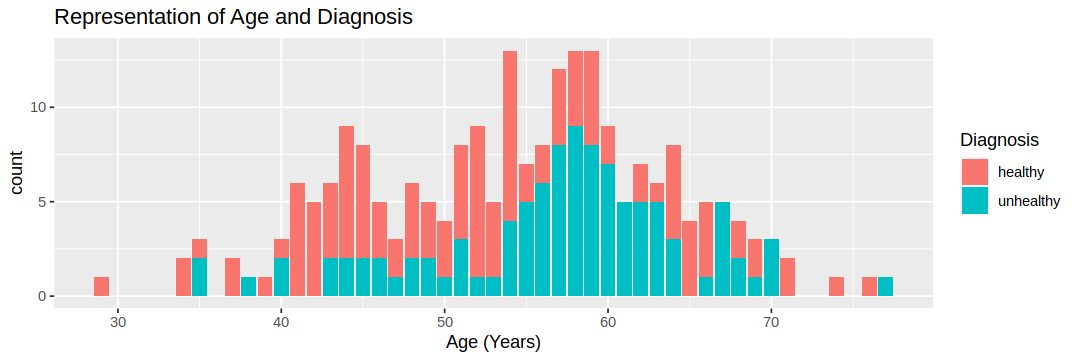

In [5]:
# A bar graph of each variable in relation to the diagnosis
# we have commented out all  our graphs but one for improved readability if we want to see said graphs we can uncomment the graph
options(repr.plot.width = 9, repr.plot.height = 3)

heart_disease_age_graph <- ggplot(heart_disease_prelim_training, aes(x = age, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Age and Diagnosis") + 
                           labs(x = "Age (Years)", fill = "Diagnosis", stat = "Count")
heart_disease_cp_graph <- ggplot(heart_disease_prelim_training, aes(x = cp, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Chest Pain Types and Diagnosis") + 
                           labs(x = "Chest Pain Types", fill = "Diagnosis", stat = "Count")
heart_disease_sex_graph <- ggplot(heart_disease_prelim_training, aes(x = sex, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Sex and Diagnosis") + 
                           labs(x = "Sex", fill = "Diagnosis", stat = "Count")
heart_disease_trestbps_graph <- ggplot(heart_disease_prelim_training, aes(x = trestbps, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Resting Blood Pressure and Diagnosis") + 
                           labs(x = "Resting Blood Pressure (mmHg)", fill = "Diagnosis", stat = "Count")
heart_disease_chol_graph <- ggplot(heart_disease_prelim_training, aes(x = chol, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Serum Cholesterol and Diagnosis") + 
                           labs(x = "Serum Cholesterol (mg/dl)", fill = "Diagnosis", stat = "Count")
heart_disease_fbs_graph <- ggplot(heart_disease_prelim_training, aes(x = fbs, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Fasting Blood Sugar and Diagnosis") + 
                           labs(x = "Fasting Blood Sugar (> 120mg/dl)", fill = "Diagnosis", stat = "Count")
heart_disease_restecg_graph <- ggplot(heart_disease_prelim_training, aes(x = restecg, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Resting ECG Results and Diagnosis") + 
                           labs(x = "Resting ECG Results", fill = "Diagnosis", stat = "Count")
heart_disease_thalach_graph <- ggplot(heart_disease_prelim_training, aes(x = thalach, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Max Heart Rate and Diagnosis") + 
                           labs(x = "Max Heart Rate", fill = "Diagnosis", stat = "Count")
heart_disease_exang_graph <- ggplot(heart_disease_prelim_training, aes(x = exang, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Exercised Induced Angina and Diagnosis") + 
                           labs(x = "Exercised Induced Angina", fill = "Diagnosis", stat = "Count")
heart_disease_oldpeak_graph <- ggplot(heart_disease_prelim_training, aes(x = oldpeak, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of ST Depression and Diagnosis") + 
                           labs(x = "ST Depression Relative To Rest", fill = "Diagnosis", stat = "Count")
heart_disease_slope_graph <- ggplot(heart_disease_prelim_training, aes(x = slope, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Slope of Peak Exercise ST and Diagnosis") + 
                           labs(x = "Slope of Peak Exercise ST", fill = "Diagnosis", stat = "Count")
heart_disease_ca_graph <- ggplot(heart_disease_prelim_training, aes(x = ca, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Number of Major Vessels and Diagnosis") + 
                           labs(x = "Number of Major Vessels Colored By Fluoroscopy", fill = "Diagnosis", stat = "Count")
heart_disease_thal_graph <- ggplot(heart_disease_prelim_training, aes(x = thal, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Defect Type and Diagnosis") + 
                           labs(x = "Defect Type", fill = "Diagnosis", stat = "Count")
heart_disease_age_graph
#heart_disease_cp_graph
#heart_disease_sex_graph
#heart_disease_trestbps_graph
#heart_disease_chol_graph
#heart_disease_fbs_graph
#heart_disease_restecg_graph
#heart_disease_thalach_graph
#heart_disease_exang_graph
#heart_disease_oldpeak_graph
#heart_disease_slope_graph
#heart_disease_ca_graph
#heart_disease_thal_graph

### Methods

We will be selecting 11 variables out of the 13. We eliminated the variables through observation over the various graphs, and we found that sex and fasting blood sugar does not vary greatly depending on whether heart disease is present, and as such these variables will not greatly affect our final prediction. Thus, we removed those variables from our prediction. We will conduct our data analysis through a K-nearest-neighbours algorithm classification and will be using five nearest neighbours (k = 5) to determine whether a patient has heart disease. We will visualize our data by using graphs to represent the two strongest variables which appear to be age and maximum heart rate. These graphs will have points on where we are predicting whether a patient has heart disease. 

[something about using numerics instead of factors]

In [7]:
heart_disease_data <- read_csv(url, 
                               col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
                                             "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
                        mutate(num = as_factor(num)) |> 
                        mutate(diagnosis = fct_recode(num, "healthy" = "0", "unhealthy" = "1" , "unhealthy" = "2", "unhealthy" = "3" , "unhealthy" = "4")) |>
                        select(-sex, -fbs, -num) |>
                        filter(ca != "?") |> 
                        filter(thal != "?") |>
                        mutate(ca = as.numeric(ca)) |>
                        mutate(thal = as.numeric(thal))
heart_disease_data

#Here we split the training data to use for our classifications
set.seed(3456)
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = diagnosis)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,233,2,150,0,2.3,3,0,6,healthy
67,4,160,286,2,108,1,1.5,2,3,3,unhealthy
67,4,120,229,2,129,1,2.6,2,2,7,unhealthy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,4,144,193,0,141,0,3.4,2,2,7,unhealthy
57,4,130,131,0,115,1,1.2,2,1,7,unhealthy
57,2,130,236,2,174,0,0.0,2,1,3,unhealthy


[something about regressions and standardization]

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         11

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7794949,5,0.01731638,Preprocessor1_Model01
1,roc_auc,binary,0.7788095,5,0.01706435,Preprocessor1_Model01
2,accuracy,binary,0.7794949,5,0.01731638,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,roc_auc,binary,0.9128175,5,0.01270815,Preprocessor1_Model29
30,accuracy,binary,0.8564646,5,0.02989899,Preprocessor1_Model30
30,roc_auc,binary,0.9143552,5,0.01147586,Preprocessor1_Model30


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7794949,5,0.01731638,Preprocessor1_Model01
2,accuracy,binary,0.7794949,5,0.01731638,Preprocessor1_Model02
3,accuracy,binary,0.8156566,5,0.02432331,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,binary,0.8610101,5,0.03215923,Preprocessor1_Model28
29,accuracy,binary,0.8564646,5,0.02989899,Preprocessor1_Model29
30,accuracy,binary,0.8564646,5,0.02989899,Preprocessor1_Model30


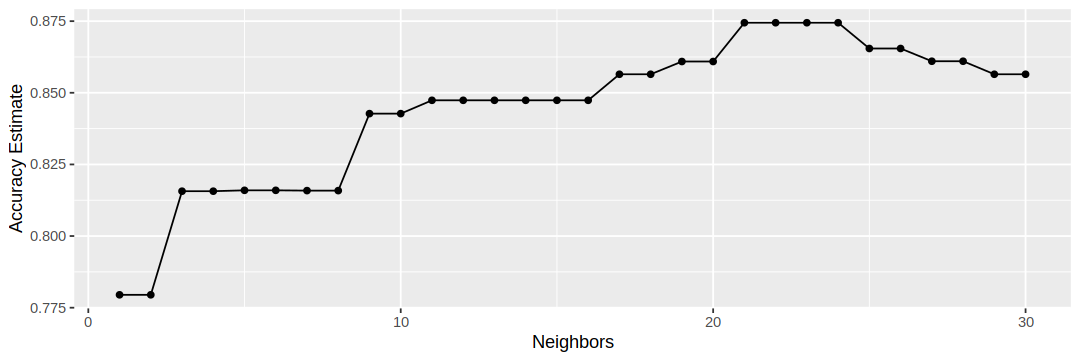

In [16]:
heart_disease_recipe = recipe(diagnosis ~ ., heart_disease_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
heart_disease_recipe

knn_tuning = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
knn_tuning

set.seed(3456)
heart_disease_vfold = vfold_cv(heart_disease_training, v = 5, strata = diagnosis)
k_vals = tibble(neighbors = seq(1, 30, 1))

tuning_workflow = workflow() |>
       add_recipe(heart_disease_recipe) |>
       add_model(knn_tuning) |>
       tune_grid(resamples = heart_disease_vfold, grid = k_vals)

tuning_metrics = tuning_workflow |>
    collect_metrics()
tuning_metrics

accuracies <- tuning_metrics |> 
       filter(.metric == "accuracy")
accuracies

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_versus_k

[something about k = 8]

In [16]:
knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_disease_recipe = recipe(diagnosis ~ age + cp + trestbps + chol + restecg + thalach + exang + oldpeak + slope + ca + thal, heart_disease_num_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_disease_fit = workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(knn_spec) |>
    fit(heart_disease_num_training)

heart_disease_conf_mat = heart_disease_fit |>
    predict(heart_disease_num_training) |>
    bind_cols(heart_disease_num_training) |>
    conf_mat(diagnosis, .pred_class)
heart_disease_conf_mat

heart_disease_test_conf_mat = heart_disease_fit |>
    predict(heart_disease_num_testing) |>
    bind_cols(heart_disease_num_testing) |>
    conf_mat(diagnosis, .pred_class)
heart_disease_test_conf_mat

           Truth
Prediction  healthy unhealthy
  healthy       108        20
  unhealthy      12        82

           Truth
Prediction  healthy unhealthy
  healthy        37        13
  unhealthy       3        22

### Expected Outcome

1.What do you expect to find? We expect to find that there is a direct relationship between the predictors used and the heart conditions of our patients. \
2.What impact could such findings have? The findings will allow us to predict whether a patent has heart disease. It will allow for faster treatment of heart disease and may result in the patients having larger life expectancies. \
3.What future questions could this lead to?
- Which factors are affected by biological aspects and which are affected by lifestyles?
- Which factor plays the greatest role in heart disease determination?
- Does this relation vary by region?
